In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import Image
import matplotlib.patches as patches
from PIL import Image

In [3]:
# Import openstreetmap
import osmnx as ox
import geojson 
import geopandas as gpd

In [9]:
# Define the area of interest (AOI). Dominica OSMID = "R7161200"
place_name = "Dominica"
area_of_interest = ox.geocode_to_gdf(query="R7161200", by_osmid=True)
area_of_interest

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-61.48012 15.53727, -61.47996 15.536...",15.640275,15.207632,-61.240093,-61.480117,277571046,relation,7161200,15.424043,-61.341853,place,island,17,0.678697,island,Dominica,"Dominica, Roseau, Saint Joseph Parish, Dominica"


Geometry is valid for OSMnx.


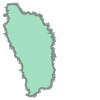

In [10]:
#convert GDF to polygon and check its valid for OSMNX

from shapely.geometry import Polygon, MultiPolygon

# Assuming `area of interest` contains a single row with the area of interest
area_of_interest_poly = area_of_interest.geometry.iloc[0]

# Ensure it's a valid polygon or multipolygon for OSMnx
if isinstance(area_of_interest_poly, (Polygon, MultiPolygon)):
    print("Geometry is valid for OSMnx.")
else:
    raise ValueError("The geometry is not a Polygon or MultiPolygon.")
area_of_interest_poly

In [6]:
#Get bridges from area of interest
bridges = ox.features_from_polygon(area_of_interest_poly, tags={
    'bridge': True
    })

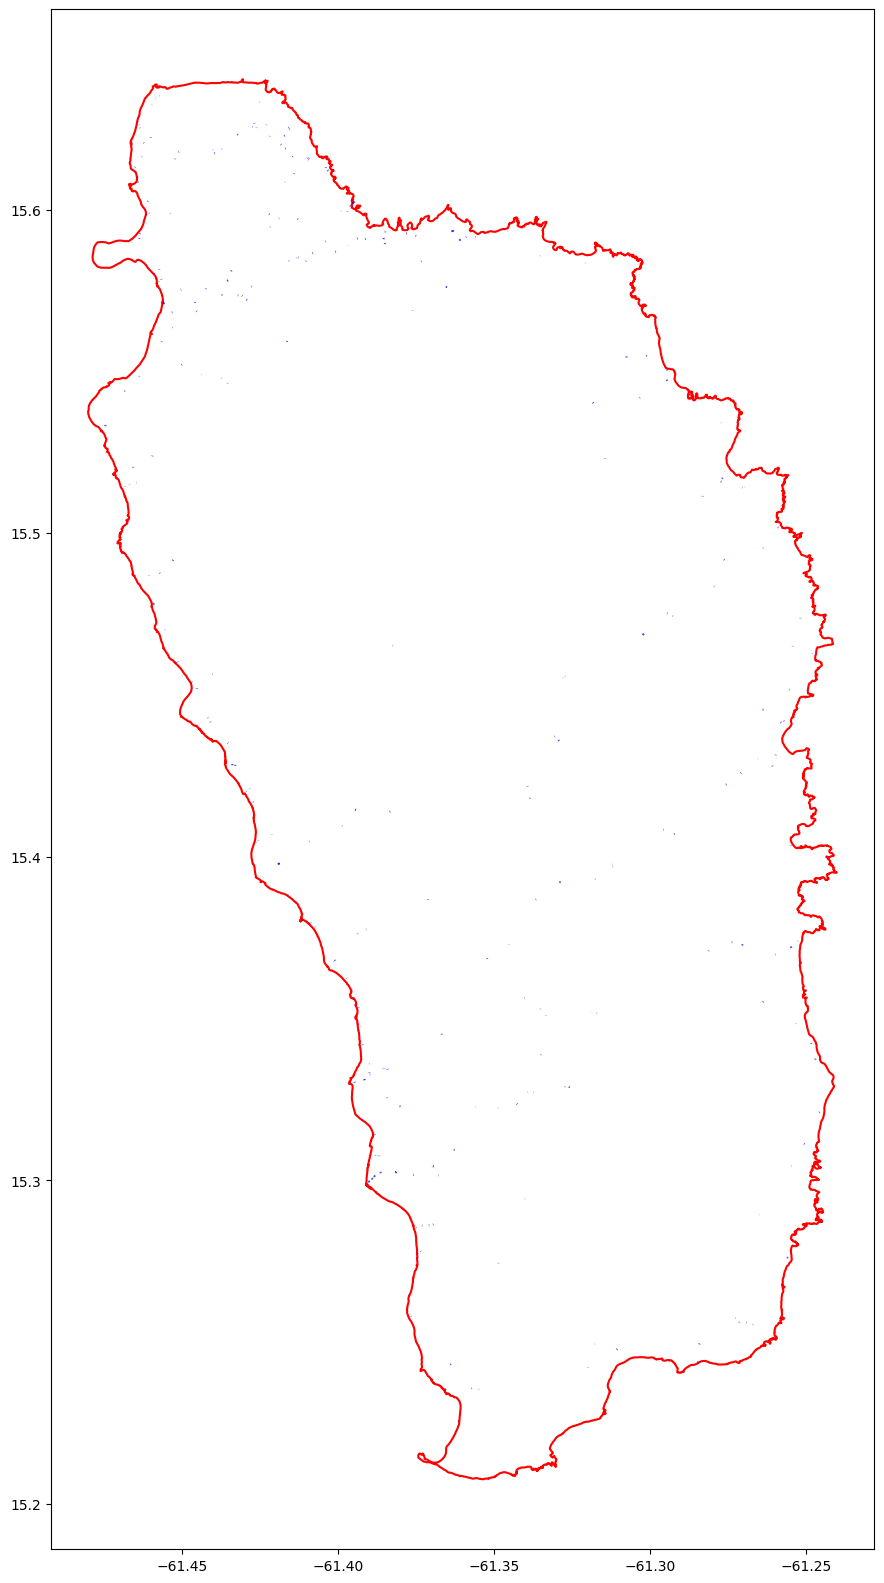

In [13]:
# Plot the area and buildings for visualization

fig, ax = plt.subplots(figsize=(20,20))
area_of_interest.boundary.plot(ax=ax, color="red")
bridges.plot(ax=ax, color="blue", alpha=0.7)
plt.show()

In [ ]:
bridges
# Save the building footprints for further use
bridges.to_file("./Data/dominica_all_bridges.geojson", driver="GeoJSON")
#Don't know why this throws an error it seems to work fine.

# Filter bridges to remove footpaths etc that are not roads or visible from space
# Could be done through checking against distance from roads and/riverways


In [ ]:
#Overlay bridges to Satellite imagery
#get the sentinel-2 imagery from  sentinelhub . Other options will work as well.
from sentinelhub import SHConfig
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, bbox_to_dimensions, BBox, CRS

#sign up for an account here: https://www.sentinel-hub.com/develop/dashboard/
# Load SentinelHub configuration
config = SHConfig()
config.instance_id = ''
config.sh_client_id = ''
config.sh_client_secret = ''

In [17]:
# Coordinates for Dominica
bounds = area_of_interest.total_bounds  # returns [minx, miny, maxx, maxy]
dominica_bbox = BBox(bbox=[bounds[0], bounds[1], bounds[2], bounds[3]], crs=CRS.WGS84) #Need to specifiy the coordinate system
dominica_bbox

BBox(((-61.4801175, 15.2076318), (-61.2400927, 15.6402755)), crs=CRS('4326'))

In [18]:
# Define the resolution (10m per pixel)
resolution = 10  # 10 meters per pixel.
size = bbox_to_dimensions(dominica_bbox, resolution)

In [33]:
# Define the Sentinel-2 imagery request (True Color Composite)
request = SentinelHubRequest(
    evalscript="""
        // Normalized True Color script
        return [B04 * 2.5, B03 * 2.5, B02 * 2.5]; // Sentinel-2 bands for RGB
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2017-08-01', '2017-09-01')  # Date range before hurricane
        )
    ],
    data_folder= "~/Data/",
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=dominica_bbox,
    size=bbox_to_dimensions(dominica_bbox, resolution),
    config=config
)

In [34]:
# Execute the request and save the image
image_data = request.get_data(save_data=True)

InvalidClientError: (invalid_client) Invalid client or Invalid client credentials

In [ ]:
#Visualise it
image = image_data[0]
fig, ax = plt.subplots(1, 1)
ax.imshow(image)

In [22]:
SHConfig.get_config_location()

'C:\\Users\\Rich\\.config\\sentinelhub\\config.toml'